# TF-try

# Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.1


# Import Dataset

In [3]:
raw_dataset = pd.read_csv("car_prices.csv", on_bad_lines="skip")

In [5]:
df = raw_dataset.copy()
df.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


## Get an overview

In [6]:
print(f"We have {len(df.index):,} observations and {len(df.columns)} columns in our dataset.")

We have 558,811 observations and 16 columns in our dataset.


In [7]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


# Clean the data

## Remove unnessecary columns

* trim
* vin
* mmr

In [10]:
df = df.drop(["trim", "vin", "mmr"], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   body          545616 non-null  object 
 4   transmission  493458 non-null  object 
 5   state         558811 non-null  object 
 6   condition     547017 non-null  float64
 7   odometer      558717 non-null  float64
 8   color         558062 non-null  object 
 9   interior      558062 non-null  object 
 10  seller        558811 non-null  object 
 11  sellingprice  558811 non-null  int64  
 12  saledate      558811 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 55.4+ MB


## Rename columns

In [12]:
df = df.rename(columns={
"make" : "brand",
"body" : "type",
"transmission" : "drivetrain",
"odometer" : "miles"} 
    )

## Remove missing values



In [13]:
# Check for missing values
df.isna().sum()

year                0
brand           10301
model           10399
type            13195
drivetrain      65353
state               0
condition       11794
miles              94
color             749
interior          749
seller              0
sellingprice        0
saledate            0
dtype: int64

In [14]:
# Drop missing values
df = df.dropna()

In [15]:
# Check missing values again
df.isna().sum()

year            0
brand           0
model           0
type            0
drivetrain      0
state           0
condition       0
miles           0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

## Transform in lowercase

In [16]:
df["brand"] = df["brand"].str.lower()
df["model"] = df["model"].str.lower()
df["type"] = df["type"].str.lower()

In [17]:
df["brand"].head()

0      kia
1      kia
2      bmw
3    volvo
4      bmw
Name: brand, dtype: object

# Categorical or numeric?

* year = categorial
* brand = categorial
* model = categorial
* type = categorial
* drivetrain = categorial
* state = categorial
* condition = categorial
* miles = numeric
* color = categorial
* interior = categorial
* seller = categorial
* ratingprice = numeric
* sellingprice = numeric
* saledate = categorial

In [23]:
# Transform into categorical

for cat in ["year", "brand", "model", "type", "drivetrain", "state", "condition", "color", "interior", "seller", "saledate"]:
    df[cat] = df[cat].astype("category")


df.dtypes

year            category
brand           category
model           category
type            category
drivetrain      category
state           category
condition       category
miles            float64
color           category
interior        category
seller          category
sellingprice       int64
saledate        category
dtype: object

In [88]:
df["sellingprice"] = df["sellingprice"].astype(float)

## Prepare the data



In [70]:
# list of all numerical data
list_num = df.select_dtypes(include=[np.number]).columns.tolist()

# list of all categorical data
list_cat = df.select_dtypes(include=['category']).columns.tolist()

print(list_num, list_cat)

['miles', 'sellingprice'] ['year', 'brand', 'model', 'type', 'drivetrain', 'state', 'condition', 'color', 'interior', 'seller', 'saledate']


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [71]:
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.



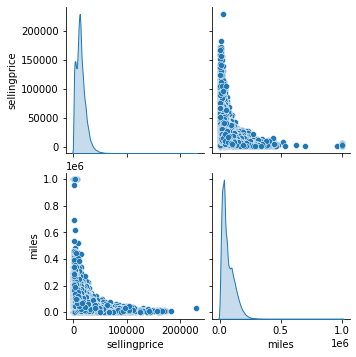

In [72]:
sns.pairplot(df_train[['sellingprice', 'miles']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [73]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
miles,377869.0,66684.354459,51764.455886,1.0,28160.0,51091.0,96636.0,999999.0
sellingprice,377869.0,13680.539830,9596.135230,1.0,7200.0,12200.0,18200.0,230000.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [91]:
train_features = df_train.copy()
test_features = df_test.copy()

train_labels = train_features.pop('sellingprice')
test_labels = test_features.pop('sellingprice')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [93]:
#train_features =train_features.to_numpy()
train_features = tf.convert_to_tensor(train_features)

print(type(train_features))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [94]:
train_features

array([[1996, 'toyota', 'camry', ..., 'gray',
        'purple heart services inc',
        'Tue Feb 17 2015 04:30:00 GMT-0800 (PST)'],
       [2011, 'nissan', 'altima', ..., 'black',
        'remarketing by ge/flagship credit acceptance',
        'Tue Feb 10 2015 01:30:00 GMT-0800 (PST)'],
       [2009, 'honda', 'accord', ..., 'gray',
        'ahfc/honda lease trust/hvt, inc.',
        'Thu Dec 18 2014 10:00:00 GMT-0800 (PST)'],
       ...,
       [2002, 'jeep', 'grand cherokee', ..., 'gray',
        'langley management services, llc',
        'Thu Jan 29 2015 01:00:00 GMT-0800 (PST)'],
       [2003, 'gmc', 'sierra 1500', ..., 'gray', 'dt credit corporation',
        'Tue Jan 20 2015 01:30:00 GMT-0800 (PST)'],
       [2010, 'chevrolet', 'camaro', ..., 'black',
        'national auto lenders inc',
        'Thu Feb 12 2015 03:00:00 GMT-0800 (PST)']], dtype=object)

In [40]:
df_train.describe().transpose()[['mean', 'std']]

,mean,std
miles,66684.354459,51764.455886
sellingprice,13680.539830,9596.135230


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [41]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [50]:
tf.dtypes.DType()


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. tensorflow.python.framework._dtypes.DType(arg0: object)

Invoked with: 

In [42]:
normalizer.adapt(np.array(train_features))

2022-04-25 13:22:11.847314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

Calculate the mean and variance, and store them in the layer:

In [43]:
print(normalizer.mean.numpy())

AttributeError: 'Normalization' object has no attribute 'mean'

When the layer is called, it returns the input data, with each feature independently normalized:

In [82]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[1996 'toyota' 'camry' 'sedan' 'automatic' 'md' 2.0 214227.0 'red'
  'gray' 'purple heart services inc'
  'Tue Feb 17 2015 04:30:00 GMT-0800 (PST)']]



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [77]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [78]:
linear_model.predict(train_features[:10])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [79]:
linear_model.layers[1].kernel

AttributeError: 'Dense' object has no attribute 'kernel'

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [80]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [81]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

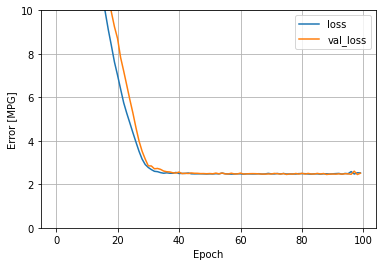

In [38]:
plot_loss(history)

Collect the results on the test set for later:

In [39]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [40]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [41]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [42]:
dnn_horsepower_model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 normalization_1 (Normalizat  (None, 1)                3         


 ion)                                                            


 dense_2 (Dense)             (None, 64)                128       


 dense_3 (Dense)             (None, 64)                4160      


 dense_4 (Dense)             (None, 1)                 65        


Total params: 4,356


Trainable params: 4,353


Non-trainable params: 3


_________________________________________________________________


Train the model with Keras `Model.fit`:

In [43]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.83 s, sys: 829 ms, total: 5.66 s
Wall time: 3.8 s


This model does slightly better than the linear single-input `horsepower_model`:

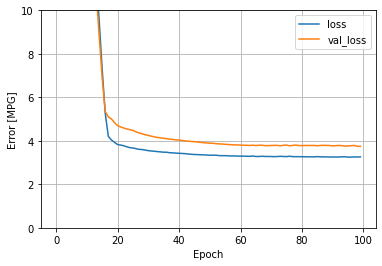

In [44]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

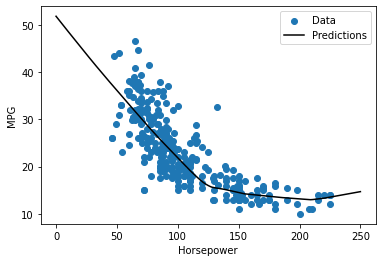

In [46]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [47]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [48]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 normalization (Normalizatio  (None, 9)                19        


 n)                                                              


 dense_5 (Dense)             (None, 64)                640       


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 1)                 65        


Total params: 4,884


Trainable params: 4,865


Non-trainable params: 19


_________________________________________________________________


In [49]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.06 s, sys: 652 ms, total: 5.71 s
Wall time: 3.82 s


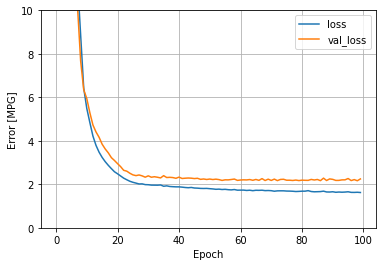

In [50]:
plot_loss(history)

Collect the results on the test set:

In [51]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.644899
linear_model,2.545512
dnn_horsepower_model,2.921918
dnn_model,1.687110


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

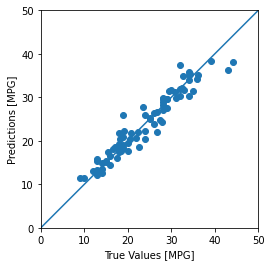

In [53]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

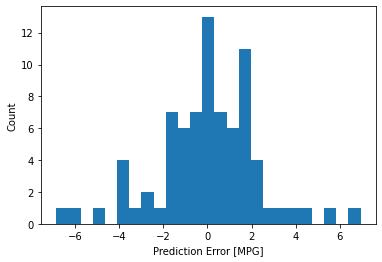

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [55]:
dnn_model.save('dnn_model')

2022-02-10 18:50:01.821887: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [56]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.644899
linear_model,2.545512
dnn_horsepower_model,2.921918
dnn_model,1.687110
reloaded,1.687110


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.